In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb

In [3]:
diag = pd.read_csv('C:\\Users\\yahya\\Documents\\GitHub\\Internship\\CSV_files\\diagnoses_table.csv')


In [4]:
def detect_icd_version(code):
    code = str(code).strip().upper()
    return 10 if code and code[0].isalpha() else 9

# Apply to your DataFrame
diag['icd_version'] = diag['icd_code'].apply(detect_icd_version)

In [5]:
diag.head(10)

,subject_id,hadm_id,icd_code,icd_version
0,13757356,22748649,V1083,10
1,13781225,21231709,3572,9
2,13786252,21097730,36250,9
3,13799390,22090873,V8535,10
4,13870030,28791864,2572,9
5,13872674,25090386,60784,9
6,13886433,29507168,7840,9
7,13916179,28451236,2858,9
8,13962855,24639924,2762,9
9,13993861,28782751,2859,9


In [6]:
adm = pd.read_csv('C:\\Users\\Yahya\\Documents\\GitHub\\Internship\\CSV_files\\admissions_table.csv')

In [7]:
adm.head(10)

,subject_id,hadm_id,admittime,dischtime
0,10106244,26713233,2147-05-09 10:34:00,2147-05-12 13:43:00
1,10106244,26738324,2147-05-09 10:34:00,2147-05-12 13:43:00
2,10106244,22486493,2147-05-09 10:34:00,2147-05-12 13:43:00
3,15443666,22294409,2168-12-30 23:30:00,2169-01-05 16:02:00
4,15443666,24613632,2168-12-30 23:30:00,2169-01-05 16:02:00
5,15443666,25959308,2168-12-30 23:30:00,2169-01-05 16:02:00
6,15443666,22121441,2168-12-30 23:30:00,2169-01-05 16:02:00
7,15443666,27961368,2168-12-30 23:30:00,2169-01-05 16:02:00
8,15443666,29035604,2168-12-30 23:30:00,2169-01-05 16:02:00
9,16299919,29997664,2193-05-15 08:37:00,2193-05-17 16:03:00


In [8]:
diag_df = diag.merge(adm, on=['subject_id', 'hadm_id'])

In [9]:
diag_df.head(10)

,subject_id,hadm_id,icd_code,icd_version,admittime,dischtime
0,13757356,22748649,V1083,10,2142-11-11 21:51:00,2142-11-12 12:34:00
1,13757356,22748649,V1083,10,2148-04-01 21:22:00,2148-04-03 14:32:00
2,13757356,22748649,V1083,10,2148-04-03 19:53:00,2148-04-05 14:08:00
3,13757356,22748649,V1083,10,2149-09-18 22:18:00,2149-09-19 17:08:00
4,13757356,22748649,V1083,10,2148-07-21 06:40:00,2148-07-30 17:00:00
5,13757356,22748649,V1083,10,2147-06-19 19:56:00,2147-06-21 17:46:00
6,13757356,22748649,V1083,10,2148-02-25 20:41:00,2148-03-01 16:00:00
7,13757356,22748649,V1083,10,2148-06-29 01:10:00,2148-07-03 15:50:00
8,13781225,21231709,3572,9,2130-02-27 04:47:00,2130-03-05 16:35:00
9,13786252,21097730,36250,9,2142-12-01 01:10:00,2142-12-11 15:11:00


In [10]:
diag_df.shape

(44474993, 6)

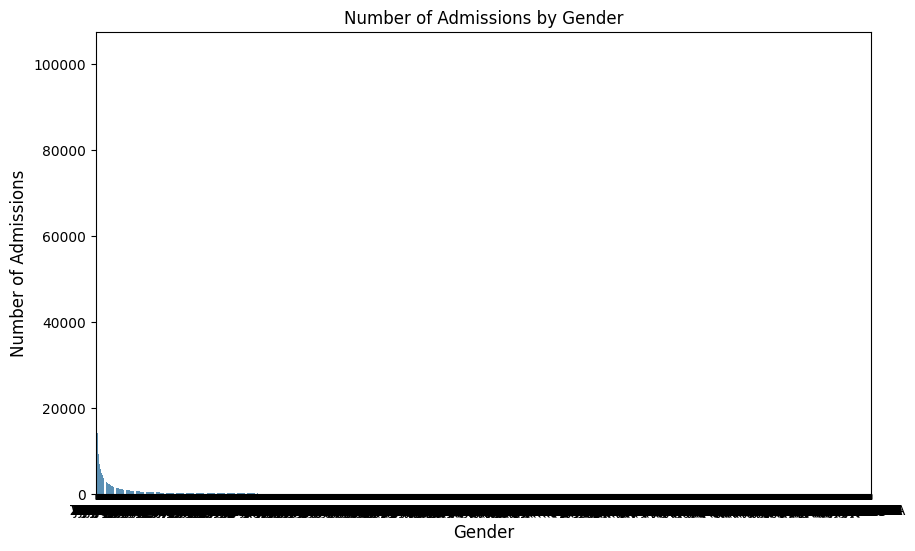

In [ ]:
import plotly.express as px
import streamlit as st

icd_count = diag['icd_code'].value_counts()
top_20_diag = icd_count.head(20)
top_20_df = top_20_diag.reset_index()
top_20_df.columns = ['icd_code', 'count']

st.header("Top 20 Diagnoses")

fig = px.bar(
    top_20_df,
    x='icd_code',
    y='count',
    title="Top 20 Diagnoses by Count",
    labels={'icd_code': 'ICD Code', 'count': 'Count'}
)

st.plotly_chart(fig, use_container_width=True)

In [28]:
import streamlit as st
import pandas as pd
import plotly.express as px

# Load your combined CSV or DataFrame
df = diag_df.copy()

st.title("Visualization Patient Data MIMIC-IV dataset")

# Optional: filter by subject_id or hadm_id
subject_ids = df['subject_id'].unique()
selected_subject = st.selectbox("Select Subject ID", subject_ids)

filtered_df = df[df['subject_id'] == selected_subject]

# Create timeline plot

st.header("Timeline Plot")

fig = px.timeline(
    filtered_df,
    x_start="admittime",
    x_end="dischtime",
    y="icd_code",
    color="icd_version",
    title=f"ICD Diagnosis Timeline for Subject {selected_subject}",
    hover_data=["hadm_id"]
)

fig.update_yaxes(autorange="reversed")  # Timeline style
st.plotly_chart(fig, use_container_width=True)


2025-05-15 16:08:58.443 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-05-15 16:08:58.655 
  command:

    streamlit run c:\Users\yahya\Documents\GitHub\Internship\venv\Lib\site-packages\ipykernel_launcher.py [ARGUMENTS]
2025-05-15 16:08:58.656 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-05-15 16:08:59.133 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-05-15 16:08:59.134 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-05-15 16:08:59.178 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-05-15 16:08:59.189 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-05-15 16:08:59.190 

DeltaGenerator()

In [ ]:
# streamlit_app.py
import streamlit as st
import pandas as pd
import plotly.graph_objects as go

st.title("🌀 Patient Diagnosis Transitions (Sankey)")

# ---------- STEP 1: Load Admissions ----------
@st.cache_data
def load_admissions():
    adm = pd.read_csv('C:\\Users\\Yahya\\Documents\\GitHub\\Internship\\CSV_files\\admissions_table.csv', parse_dates=["admittime"])
    adm['admission_number'] = adm.groupby('subject_id')['admittime'].rank(method='dense').astype(int)
    return adm

adm = load_admissions()

# Keep only patients with 2+ admissions
adm_counts = adm['subject_id'].value_counts()
valid_subjects = adm_counts[adm_counts >= 2].index
adm = adm[adm['subject_id'].isin(valid_subjects)]

# ---------- STEP 2: Load Diagnoses ----------
@st.cache_data
def load_diagnoses():
    diag = pd.read_csv("C:\\Users\\Yahya\\Documents\\GitHub\\Internship\\CSV_files\\diagnoses_table.csv")
    return diag

diag = load_diagnoses()

# Filter to matching subject_ids
diag = diag[diag['subject_id'].isin(valid_subjects)]

# Merge admittime and admission number
diag = diag.merge(adm[['subject_id', 'hadm_id', 'admittime', 'admission_number']], on=['subject_id', 'hadm_id'])

diag['icd_code_clean'] = diag['icd_code'].astype(str).str.strip().str.upper()
diag['icd_version'] = diag['icd_version'].astype(int)
def classify_icd(row):
    code = row['icd_code_clean']
    version = row['icd_version']

    if version == 10:
        category = code[:3]

        if category >= 'A00' and category <= 'B99':
            return "Infectious diseases"
        elif category >= 'C00' and category <= 'D49':
            return "Neoplasms"
        elif category >= 'D50' and category <= 'D89':
            return "Blood Diseases"
        elif category >= 'E00' and category <= 'E89':
            return "Endocrine, nutritional, metabolic"
        elif category >= 'F01' and category <= 'F99':
            return "Mental, Behavioral and Neurodevelopmental"
        elif category >= 'G00' and category <= 'G99':
            return "Diseases of the Nervous System"
        elif category >= 'H00' and category <= 'H59':
            return "Diseases of the Eye"
        elif category >= 'H60' and category <= 'H99':
            return "Diseases of the Ear"
        elif category >= 'I00' and category <= 'I99':
            return "Circulatory diseases"
        elif category >= 'J00' and category <= 'J99':
            return "Respiratory diseases"
        elif category >= 'K00' and category <= 'K95':
            return "Digestive diseases"
        elif category >= 'L00' and category <= 'L99':
            return "Skin diseases"
        elif category >= 'M00' and category <= 'M99':
            return "Musculoskeletal diseases"
        elif category >= 'N00' and category <= 'N99':
            return "Genitourinary diseases"
        elif category >= 'V00' and category <= 'Y99':
            return "External Causes of Morbidity"
        elif category >= 'Z00' and category <= 'Z99':
            return "Health status & services"
        else:
            return "Other ICD-10"

    elif version == 9:
        code_padded = code.zfill(5)
        try:
            code_int = int(code_padded)
        except ValueError:
            return "Invalid ICD-9"

        if 1 <= code_int <= 13900:
            return "Infectious And Parasitic Diseases"
        elif 14000 <= code_int <= 23999:
            return "Neoplasms"
        elif 24000 <= code_int <= 27999:
            return "Endocrine, Nutritional And Metabolic Diseases, And Immunity Disorders"
        elif 28000 <= code_int <= 28999:
            return "Blood Diseases"
        elif 29000 <= code_int <= 31999:
            return "Mental Disorders"
        elif 32000 <= code_int <= 38999:
            return "Diseases Of The Nervous System"
        elif 39000 <= code_int <= 45999:
            return "Circulatory diseases"
        elif 46000 <= code_int <= 51999:
            return "Respiratory diseases"
        elif 52000 <= code_int <= 57999:
            return "Digestive Diseases"
        elif 58000 <= code_int <= 62999:
            return "Genitourinary Diseases"
        elif 63000 <= code_int <= 67999:
            return "Complications of Pregnancy, Childbirth And The Puerperium"
        elif 68000 <= code_int <= 70999:
            return "Skin Diseases"
        elif 71000 <= code_int <= 73999:
            return "Musculoskeletal Diseases"
        elif 74000 <= code_int <= 77999:
            return "Congenital Anomalies"
        elif 78000 <= code_int <= 79999:
            return "Symptoms/signs"
        else:
            return "Other ICD-9"
    
    else:
        return "Unknown version"

# Apply to create new column without altering original icd_code
diag['icd_group'] = diag.apply(classify_icd, axis=1)

diag['icd_group'] = diag['icd_group'].str.title().str.strip()

diag.drop(columns='icd_code_clean', inplace=True)

# ---------- STEP 4: Select 1 Diagnosis per Admission ----------
diag_unique = diag.sort_values(by=['subject_id', 'admission_number']).drop_duplicates(subset=['subject_id', 'admission_number'])

# Check: 1 row per subject_id + admission_number
assert diag_unique[['subject_id', 'admission_number']].duplicated().sum() == 0

# ---------- STEP 5: Pivot to Wide Format ----------
diag_wide = diag_unique.pivot(index='subject_id', columns='admission_number', values='icd_group').reset_index()
diag_wide = diag_wide.rename(columns={1: 'First', 2: 'Second'})
diag_wide = diag_wide.dropna(subset=['First', 'Second'])

# Count transitions
flows = diag_wide.groupby(['First', 'Second']).size().reset_index(name='count')

# ---------- STEP 6: Plot Sankey ----------
labels = list(set(flows['First']) | set(flows['Second']))
label_map = {label: i for i, label in enumerate(labels)}
sources = flows['First'].map(label_map)
targets = flows['Second'].map(label_map)
values = flows['count']

fig = go.Figure(data=[go.Sankey(
    node=dict(label=labels, pad=20, thickness=20),
    link=dict(source=sources, target=targets, value=values)
)])
fig.update_layout(title_text="Diagnosis Group Flow: Admission 1 → 2", font_size=14)
st.plotly_chart(fig, use_container_width=True)

2025-05-15 16:09:08.099 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-05-15 16:09:08.100 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-05-15 16:09:08.101 No runtime found, using MemoryCacheStorageManager
2025-05-15 16:09:08.102 No runtime found, using MemoryCacheStorageManager
2025-05-15 16:09:08.103 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-05-15 16:09:08.103 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-05-15 16:09:08.103 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-05-15 16:09:08.624 Thread 'Thread-5': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-05-15 16:09:08.628 Thread 'Thread-5': missing ScriptRunContext! This warning can be ignored w

DeltaGenerator()